# Style Transfer - Image #2
- CNN을 이용하여 Image의 Style Transfer를 실행하는 과제입니다.
- VGG19를 이용하였으며, Keras기반으로 작성되었습니다.
- 해당 문서에서는 Image #2에 대한 결과물을 출력합니다.

In [1]:
from __future__ import print_function
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from imageio import imwrite
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras import backend as K

from IPython.display import Image

%matplotlib inline

C:\Users\jungw\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
- 변경하고 싶은 원본 이미지를 Content Image라고 정의
    - 현재 작업할 이미지는 Image #1
- 적용하고 싶은 스타일 이미지를 Style Image라고 정의

In [2]:
content_image1 = "Original_Target/8ADD741DB3A046989734ACB2DFE475CB.png"
content_image2 = "Original_Target/DF8929C860BD48FEB8E3EBEFD554DB8D.png"
style_image = "Style_Image/E6EBD555B1894D4895BF84523E6CBDD4.png"

save_path = "Output_Images/"

### content_image1 이미지 상세

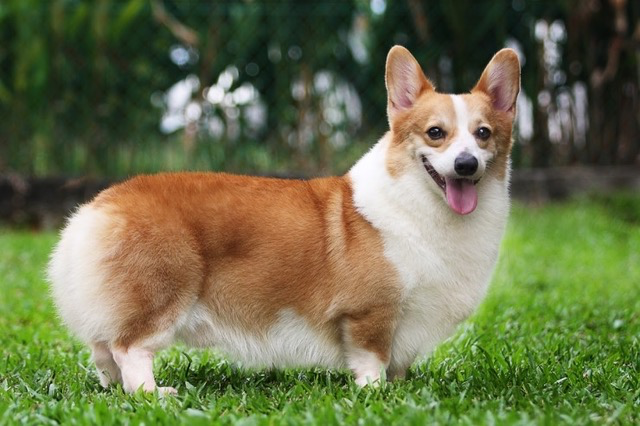

In [3]:
Image(content_image1)

### content_image2 이미지 상세

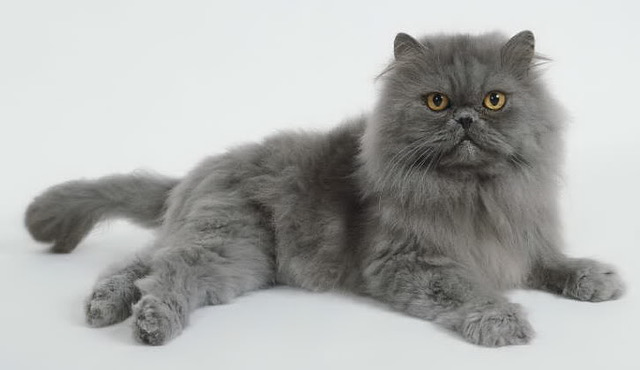

In [4]:
Image(content_image2)

### style_image 이미지 상세

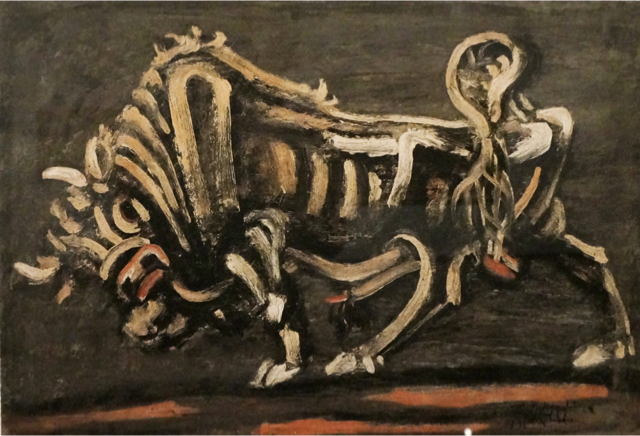

In [5]:
# Actual Image of style_image
Image(style_image)

## Hyperparameter 세팅
- 경과를 살펴보기 위해 30 Iter로 지정
- Content Weight 0.025로 설정 (모든 Layer)
- Style Weight 1.0으로 설정
    - Content Weight보다 더 높게 설정
- Total Variation Weight
    - Total Cost를 계산하기 위한 alpha & beta 종합 값

In [6]:
iterations = 30
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0

In [7]:
input_image = content_image2
name = "IMAGE_2"
width, height = load_img(input_image).size
img_ncols = 640
img_nrows = int(height * img_ncols / width)

## 이미지 처리
- preprocess_image: 이미지의 처리를 위해 image를 Array형태로 늘림
- deprocess_image: Array를 다시 이미지로 표기하기 위해 변환

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    
    return img

In [9]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Array로 변경된 이미지를 처리할 때, 표현 방식에 따라 형식을 맞춤
- Channel First: Tensorflow, Keras에서 주로 쓰이는 방식
- Channel Last: Theano에서 주로 쓰이는 방식

이후, Input은 다음 항목들을 Concat한 후, 한번에 처리
- Base Image (Content Image 또는 Original Image)
- Style Image
- Combination Image: Style이미지가 Base Image에 적용된 이미지

In [10]:
base_image = K.variable(preprocess_image(input_image))
style_reference_image = K.variable(preprocess_image(style_image))

In [11]:
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [12]:
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

### Transfer Learning with VGG19 Model
Style Transfer는 모델의 Weight값이 아닌 이미지의 Output을 변화시켜 가는 방식이므로, Pre-train된 모델을 사용합니다. 여기서는 기존 모델 중 하나인 VGG19을 사용합니다.

In [13]:
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


VGG모델의 구조를 Dictionary 형식으로 확인합니다. 기본 구조는 다음과 같이 구성되어 있습니다.
- Input
- Block 1
    - Conv Layer (370, 640, 64) * 3 Channel
    - Conv Layer (370, 640, 64) * 3 Channel
    - Max Pooling
- Block 2
    - Conv Layer (185, 320, 128) * 3 Channel
    - Conv Layer (185, 320, 128) * 3 Channel
    - Max Pooling
- Block 3
    - Conv Layer (92, 160, 256) * 3 Channel
    - Conv Layer (92, 160, 256) * 3 Channel
    - Conv Layer (92, 160, 256) * 3 Channel
    - Conv Layer (92, 160, 256) * 3 Channel
    - Max Pooling
- Block 4
    - Conv Layer (46, 80, 512) * 3 Channel
    - Conv Layer (46, 80, 512) * 3 Channel
    - Conv Layer (46, 80, 512) * 3 Channel
    - Conv Layer (46, 80, 512) * 3 Channel
    - Max Pooling
- Block 5
    - Conv Layer (23, 40, 512) * 3 Channel
    - Conv Layer (23, 40, 512) * 3 Channel
    - Conv Layer (23, 40, 512) * 3 Channel
    - Conv Layer (23, 40, 512) * 3 Channel
    - Max Pooling

In [14]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

print(outputs_dict)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 370, 640, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 370, 640, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 370, 640, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 185, 320, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 185, 320, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 185, 320, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 92, 160, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 92, 160, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 92, 160, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 92, 160, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 92, 160, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3

## Cost Calculation
Loss를 계산하기 위해서는 다음 요소가 필요합니다.
- Content Loss
- Style Loss
- Total Cost (Content Loss + Style Loss)

각 Cost는 다음 공식에 기반합니다.
- Content Cost Function
$$J_{content}^{[l](G)}=\sum (G^{[l](G)}-G^{[l](C)})^2$$
- Gram Matrix (Style Matrix)
    - $a_{W,H,k}^{[l]}=(W,H,k)$ 에서의 _Activation_으로 정의 ($k$: channel)
    - $G^{[l]}=n_c^{[l]} \times n_c^{[l]}$로 정의 ($G$: 각 Layer에서의 Correlation)
<br>Style: $$G_{kk'}^{[l](S)}=\sum_{i=1}^{n_H^{[l](S)}}\sum_{j=1}^{n_W^{[l](S)}}a_{ijk}^{[l]}$$
Generated: $$G_{kk'}^{[l](G)}=\sum_{i=1}^{n_H^{[l](G)}}\sum_{j=1}^{n_W^{[l](G)}}a_{ijk}^{[l]}$$
- Style Cost Function
$$J_{style}^{[l](S,G)}=\lVert{G^{[l](S)}-G^{[l](G)}}\rVert_F^2$$
$$=\frac1{4(n_H^{[l]}n_W^{[l]}n_c^{[l]})^2}\sum_k \sum_{k'}(G_{kk'}^{[l](S)}-G_{kk'}^{[l](G)})^2$$
- Total Cost
$$J(G)=\alpha J_{content}(C,G)+\beta J_{style}(S,G)$$

In [15]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [16]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    G = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

In [17]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [18]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [19]:
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv3']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

- 각 Layer의 Conv1에서의 Cost를 계산

In [20]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv2', 'block4_conv2',
                  'block5_conv2']

In [21]:
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

- alpha와 beta에 해당하는 loss를 계산

In [22]:
grads = K.gradients(loss, combination_image)

In [23]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

마지막으로, Output 이미지를 계산

In [24]:
f_outputs = K.function([combination_image], outputs)

In [25]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [26]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

준비가 모두 끝났으면, 다음과 같은 절차를 거쳐 Training을 진행합니다.
1. 이미지 Preprocessing(Array화)
2. Cost 계산
3. Gradient Descent
4. Back propagation
5. 이미지 Deprocess

In [27]:
evaluator = Evaluator()

In [28]:
x = preprocess_image(input_image)

In [29]:
recent = 0

for i in range(iterations):    
    print('Start of iteration', i)
    recent = i
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = save_path + name + '_at_iteration_%d.png' % i
    imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2287193000.0
Image saved as Output_Images/IMAGE_2_at_iteration_0.png
Iteration 0 completed in 12s
Start of iteration 1
Current loss value: 1466146400.0
Image saved as Output_Images/IMAGE_2_at_iteration_1.png
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 994271500.0
Image saved as Output_Images/IMAGE_2_at_iteration_2.png
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 737149000.0
Image saved as Output_Images/IMAGE_2_at_iteration_3.png
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 642581000.0
Image saved as Output_Images/IMAGE_2_at_iteration_4.png
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 601341440.0
Image saved as Output_Images/IMAGE_2_at_iteration_5.png
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 578209000.0
Image saved as Output_Images/IMAGE_2_at_iteration_6.png
Iteration 6 completed in 8s
Start of iteration 7
Current loss valu

## 결과물
Image #2의 결과

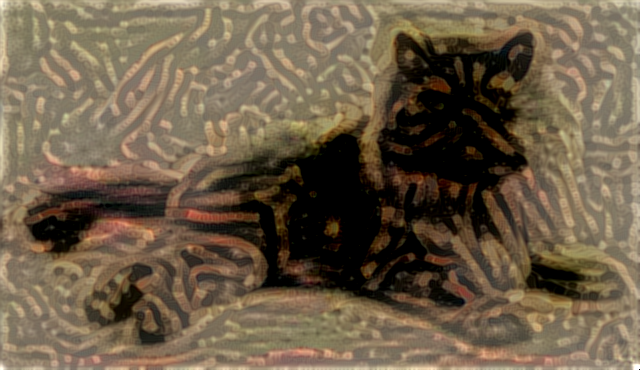

In [30]:
file = save_path + name + '_at_iteration_%d.png' % recent
Image(file)